### Using TensorTrade for Making a Simple Trading Algorithm

https://www.tensortrade.org/en/latest/tutorials/ray.html

https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c


In [1]:
# !pip install ray==0.8.7
# !pip install ray[tune,rllib]
# !pip install symfit
# !pip install dm-tree
# !pip install opencv-python
# !pip install tensorboardX
# !pip install torch torchvision
# !pip install lz4
# !pip install tabulate

### Define action

Ideally, we expect our agent to sell at the peaks and buy at the troughs. I’ll define actions that will allow us to perform this behavior. The ActionScheme I’ve built is extremely simple, relying on only two internal states: cash and asset.

State Meaning Table

The following is a transition diagram showing the states along with the actions that can be made: stay and move.

Transition Diagram

For example, if I start in cash and choose move, then I’ll transition to asset and receive P(t)-P(t-1) as a reward, where P(t) is the price of the asset at time step t. The rewards ascribed to these arrows will be described in further detail below.

In [2]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

class BSH(TensorTradeActionScheme):
    ''' 
        action: {0: buy asset, 1: sell asset}
    '''
    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 0.2)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

### Define reward

Next, I’ll create a reward scheme to reflect how well we are positioned in the environment. Essentially, we want a mapping that reflects the correct reward for each state we are in.

In [3]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

### Define renderer

Finally, we would like to make sure we can see if the agent is selling at the peaks and buying at the troughs. Here is a Renderer that can display this information using Matplotlib.

In [4]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        columns = ['bitstamp:/USD:/free','bitstamp:/USD:/locked','bitstamp:/BTC:/free','bitstamp:/BTC:/locked','bitstamp:/BTC:/worth']
        performance.drop(columns, inplace=True, axis=1)
        
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

### Retrieve data for trading

Download cryptocurrency data 

In [5]:
from tensortrade.data.cdd import CryptoDataDownload

cdd = CryptoDataDownload()

# df = cdd.fetch("Bitstamp", "USD", "BTC", "1h")
df = cdd.fetch("Bitstamp", "USD", "BTC", "d")

data = df.copy()

df.describe()

,unix,open,high,low,close,volume
count,2.353000e+03,2353.000000,2353.000000,2353.000000,2353.000000,2.353000e+03
mean,1.518739e+09,7393.879754,7624.799197,7141.450140,7417.713587,5.161336e+07
std,5.869989e+07,11106.792167,11475.554667,10699.560353,11152.643153,1.036513e+08
min,1.417133e+09,162.000000,212.840000,152.400000,162.000000,0.000000e+00
25%,1.467936e+09,585.250000,594.000000,576.010000,587.570000,8.394920e+03
50%,1.518739e+09,4606.260000,4865.000000,4435.890000,4615.000000,5.085593e+04
75%,1.569542e+09,9175.700000,9366.600000,8961.530000,9177.430000,6.206682e+07
max,1.620346e+09,63605.690000,64895.220000,61998.900000,63564.480000,1.446125e+09


In [6]:
df = df[-1000:]
df.describe()

,unix,open,high,low,close,volume
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,1.577189e+09,13691.587810,14099.902850,13257.003700,13741.781620,1.072315e+08
std,2.495400e+07,14207.453151,14690.377614,13674.626924,14271.247152,1.357533e+08
min,1.534032e+09,3180.840000,3230.000000,3122.280000,3179.540000,4.062561e+06
25%,1.555610e+09,6480.970000,6594.215000,6379.140000,6484.772500,3.244800e+07
50%,1.577189e+09,9060.625000,9221.930000,8820.810000,9071.735000,5.917681e+07
75%,1.598767e+09,11380.965000,11625.500000,11086.407500,11386.992500,1.215186e+08
max,1.620346e+09,63605.690000,64895.220000,61998.900000,63564.480000,1.446125e+09


### Train the agent

Frist, in order to use our custom environment in ray, we must write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [7]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.instruments import USD, BTC, ETH

def create_env(config):
    
    p = Stream.source(df.close, dtype="float").rename("USD-BTC")

    bitstamp = Exchange("bitstamp", service=execute_order)(
        p
    )

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0.05 * BTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
       Stream.source(df['close'], dtype="float").rename("close"),
       Stream.source(df['open'], dtype="float").rename("open"),
       Stream.source(df['high'], dtype="float").rename("high"),
       Stream.source(df['low'], dtype="float").rename("low"),
       Stream.source(df['volume'], dtype="float").rename("volume"),
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])
#     feed = DataFeed(streams)

#     renderer_feed = DataFeed([
#         Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
#     )

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)

Next, since the environment is registered, we can use the Proximal Policy Optimization (PPO) algorithm from rllib to train our agent.

To check if everything works, set a low episode_reward_mean so a fast check can be done (set at 10). Once everything is working, set it to 3000 and run the training. Once the training is complete, we can get access to the agent’s policy by restoring from the last checkpoint.

In [8]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 8000
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)



2021-05-07 21:33:24,870	INFO resource_spec.py:223 -- Starting Ray with 2.25 GiB memory available for workers and up to 1.14 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-07 21:33:25,782	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_89c81_00000,RUNNING,


                 'value_targets': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=-0.095),
(pid=28113)                         'vf_preds': np.ndarray((200,), dtype=float32, min=-1.236, max=1.546, mean=-0.005)},
(pid=28113)               'type': 'SampleBatch'}}
(pid=28113) 
(pid=28113) 2021-05-07 21:34:17,096	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=28113) 
(pid=28113) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-0.013, max=0.012, mean=-0.0),
(pid=28113)             'action_logp': np.ndarray((200,), dtype=float32, min=-0.701, max=-0.685, mean=-0.693),
(pid=28113)             'action_prob': np.ndarray((200,), dtype=float32, min=0.496, max=0.504, mean=0.5),
(pid=28113)             'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.52),
(pid=28113)             'advantages': np.ndarray((200,), dtype=float32, min=-2.546, max=2.236, mean=-0.09),
(pid=28113)             'agent_index': np.ndarray((200,), dtype=int64, min

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,RUNNING,192.168.0.249:28112,1,41.2294,4000,7753.67


(pid=28112) 2021-05-07 21:34:50,950	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.49689463339746, 'policy_loss': 0.0018611143750604242, 'vf_loss': 1.0037882775068283, 'vf_explained_var': -0.0043983106, 'kl': 4.64956920410986e-06, 'entropy': 0.6861539017409086, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:34:51,369	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.4859700482338667, 'policy_loss': -0.009082893171580508, 'vf_loss': 1.0038271378725767, 'vf_explained_var': -0.004503049, 'kl': 4.420436260943461e-05, 'entropy': 0.6869461443275213, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:34:51,802	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.4892552485689521, 'policy_loss': -0.005796174955321476, 'vf_loss': 1.0038077738136053, 'vf_explained_var': -0.00413467, 'kl': 0.0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,RUNNING,192.168.0.249:28112,2,66.0484,8000,7259.1


(pid=28112) 2021-05-07 21:35:14,646	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.503070805221796, 'policy_loss': 0.006857279047835618, 'vf_loss': 1.0062382221221924, 'vf_explained_var': -0.0072689317, 'kl': 6.046479053806175e-06, 'entropy': 0.6906190924346447, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:35:15,090	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.4890667172148824, 'policy_loss': -0.006756445043720305, 'vf_loss': 1.0054501071572304, 'vf_explained_var': -0.0060352217, 'kl': 3.80890451765481e-05, 'entropy': 0.6905703470110893, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:35:15,507	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.489193394780159, 'policy_loss': -0.006131686735898256, 'vf_loss': 1.0044105965644121, 'vf_explained_var': -0.0047319215, 'kl'

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,RUNNING,192.168.0.249:28112,3,90.1077,12000,2105.76


pid=28113) 2021-05-07 21:35:28,756	INFO sampler.py:925 -- Outputs of compute_actions():
(pid=28113) 
(pid=28113) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=28113)                       [],
(pid=28113)                       { 'action_dist_inputs': np.ndarray((1, 2), dtype=float32, min=-0.208, max=0.206, mean=-0.001),
(pid=28113)                         'action_logp': np.ndarray((1,), dtype=float32, min=-0.507, max=-0.507, mean=-0.507),
(pid=28113)                         'action_prob': np.ndarray((1,), dtype=float32, min=0.602, max=0.602, mean=0.602),
(pid=28113)                         'vf_preds': np.ndarray((1,), dtype=float32, min=-0.049, max=-0.049, mean=-0.049)})}
(pid=28113) 
(pid=28113) 2021-05-07 21:35:28,758	INFO sampler.py:509 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 5), dtype=float32, min=0.0, max=88167856.0, mean=3190909.25)}}
(pid=28113) 2021-05-07 21:35:28,758	INFO sampler.py:511 -- Info return from env: {0: {'agent0'

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,RUNNING,192.168.0.249:28112,4,113.333,16000,4167.95


(pid=28112) 2021-05-07 21:36:01,567	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.4921187236905098, 'policy_loss': -0.001047022407874465, 'vf_loss': 0.998877389356494, 'vf_explained_var': -0.00067673996, 'kl': 3.0010919814055237e-05, 'entropy': 0.627594942227006, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:36:02,023	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.4876186577603221, 'policy_loss': -0.004677130258642137, 'vf_loss': 0.9970850069075823, 'vf_explained_var': 0.00062366016, 'kl': 7.922324471110187e-05, 'entropy': 0.6254635397344828, 'entropy_coeff': 0.01}
(pid=28112) 2021-05-07 21:36:02,486	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.4896209370344877, 'policy_loss': -0.002435405447613448, 'vf_loss': 0.996517876163125, 'vf_explained_var': 0.001588555, 'kl': 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,RUNNING,192.168.0.249:28112,5,136.69,20000,8645.16



(pid=28112) 2021-05-07 21:36:15,400	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=20022, mean_mean=20839853.76305991, mean_std=26899864.105810836), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_89c81_00000,TERMINATED,,5,136.69,20000,8645.16


In [9]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]
print(checkpoint_path)

/Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-07_21-33-29tqkn893y/checkpoint_5/checkpoint-5


In [10]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-07 21:36:16,287	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-05-07 21:36:16,294	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f8d8a7e7a30>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
2021-05-07 21:36:16,340	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f8d8aa2caf0>}
2021-05-07 21:36:16,344	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f8d8a7e7a30>}
2021-05-07 21:36:16,349	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-05-07 21:36:16,356	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-07 21:36:16,372	DEBUG rollout_w

Now let’s get a visualization of the agent’s decision making on the sine curve by rendering the environment.

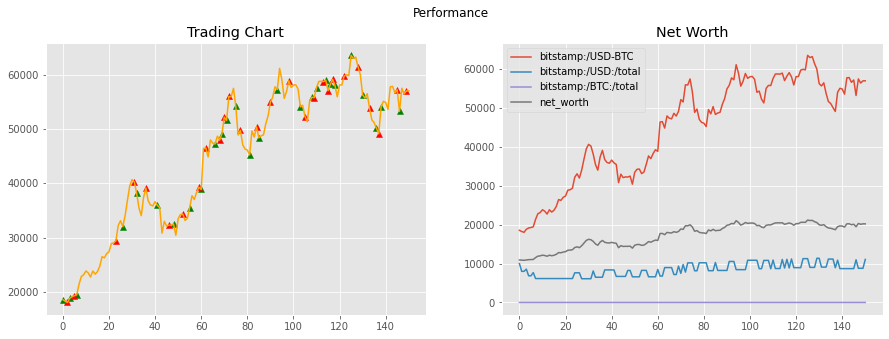

In [11]:
# Instantiate the environment
df = data[-150:]
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

# while not done:
for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    # print(env.observer.feed.next())
    episode_reward += reward

env.render()

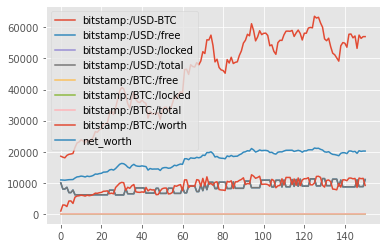

In [12]:
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')

# copy performance data to clipboard for analysis using Number
# performance.to_clipboard(index=True)
performance.to_csv('BTC_USD_Performance.csv')
performance.plot()

from pandasgui import show
gui = show(performance)

(pid=28110) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=28110) Instructions for updating:
(pid=28110) non-resource variables are not supported in the long term
(pid=28148) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=28148) Instructions for updating:
(pid=28148) non-resource variables are not supported in the long term


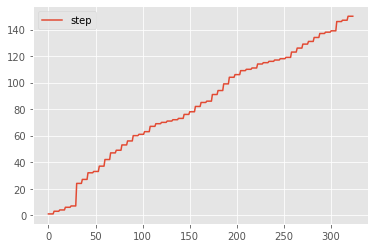

In [13]:
ledger = env.action_scheme.portfolio.ledger.as_frame()
ledger.to_csv('BTC_USD_ledger.csv')
ledger.plot()

from pandasgui import show
gui = show(ledger)

### Live trading